<a href="https://colab.research.google.com/github/wiiiiish/2022-machine_learning/blob/main/time_series_lstm_0510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
%cd drive/MyDrive/Colab\ Notebooks/2022-04-27\ 데이터

/content/drive/MyDrive/Colab Notebooks/2022-04-27 데이터


2022-05-07

In [5]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [6]:
# import library
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reprodecible
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [46]:
# data
aod_data = pd.read_csv('./data/2020-05-03_aod.csv', encoding='utf-8')
aod_data

,date_time,aod
0,2020-05-03 00:00:00,0.0
1,2020-05-03 00:00:10,0.0
2,2020-05-03 00:00:20,0.0
3,2020-05-03 00:00:30,0.0
4,2020-05-03 00:00:40,0.0
...,...,...
155516,2020-05-20 23:59:20,0.0
155517,2020-05-20 23:59:30,0.0
155518,2020-05-20 23:59:40,0.0
155519,2020-05-20 23:59:50,0.0


In [47]:
# 시간 데이터 날짜 바꾸기
for i in range(155521):
  new_day = (int)(aod_data['date_time'][i][8:10]) + 2
  if new_day < 10:
    new_day = f"0{new_day}"
  else:
    new_day = f"{new_day}"
  
  timeList = list(aod_data['date_time'][i])
  timeList[8:10] = new_day
  new_date = ''.join(s for s in timeList)

  aod_data['date_time'][i] = new_date

aod_data

,date_time,aod
0,2020-05-05 00:00:00,0.0
1,2020-05-05 00:00:10,0.0
2,2020-05-05 00:00:20,0.0
3,2020-05-05 00:00:30,0.0
4,2020-05-05 00:00:40,0.0
...,...,...
155516,2020-05-22 23:59:20,0.0
155517,2020-05-22 23:59:30,0.0
155518,2020-05-22 23:59:40,0.0
155519,2020-05-22 23:59:50,0.0


In [48]:
# dataframe -> csv
aod_data.to_csv('./data/0505-0523_aod.csv')

In [55]:
aod_0505 = aod_data.iloc[:8640,:]
aod_0505.to_csv('./data/0505_aod')

In [56]:
weather_data = pd.read_csv("./data/weather_data.csv", encoding='utf-8')
weather_data

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,05-01 00:00:00,19.471425,0.000000,1.283509,99.085068,0.0,-0.571956,2000.060648,20.859082
1,05-01 00:00:10,19.515992,0.000000,1.288677,98.906960,0.0,3.277923,2000.042480,20.930770
2,05-01 00:00:20,19.456078,0.000000,1.053963,98.952560,0.0,0.779748,2000.018245,20.992075
3,05-01 00:00:30,19.369269,0.000000,1.215434,98.990665,0.0,0.660592,1999.990462,20.983526
4,05-01 00:00:40,19.518434,0.000000,1.225970,99.000163,0.0,4.247148,2000.043941,20.894728
...,...,...,...,...,...,...,...,...,...
527035,06-30 23:59:10,25.494836,0.237966,0.546747,90.711643,0.0,9.445173,0.000000,27.381028
527036,06-30 23:59:20,25.428284,0.278660,0.675943,90.426103,0.0,9.788200,0.000000,27.304989
527037,06-30 23:59:30,25.400970,0.161461,0.643305,90.306220,0.0,8.804747,0.000000,27.346739
527038,06-30 23:59:40,25.503257,0.083391,0.789334,90.616037,0.0,9.496567,0.000000,27.327265


In [65]:
weather_0505 = weather_data.iloc[34560:43200,:]
weather_0505

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114
34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559
34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335
34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727
34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515
...,...,...,...,...,...,...,...,...,...
43195,05-05 23:59:10,20.823070,0.0,0.900223,99.083700,0.0,1.462444,941.224556,21.147663
43196,05-05 23:59:20,20.629803,0.0,0.901650,99.079732,0.0,1.555491,1180.409768,21.065588
43197,05-05 23:59:30,20.639215,0.0,0.908953,98.977158,0.0,0.443561,933.458536,21.096623
43198,05-05 23:59:40,20.788708,0.0,0.899667,99.015539,0.0,0.437883,985.787304,21.205976


In [68]:
weather_0505.to_csv('./data/weather_0505.csv')

2022-05-09 (월)

In [8]:
weather_0505 = pd.read_csv('./data/weather_0505.csv', encoding='utf-8')
aod_0505 = pd.read_csv('./data/0505_aod', encoding='utf-8')

In [25]:
weather_0505

,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114
1,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559
2,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335
3,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727
4,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515
...,...,...,...,...,...,...,...,...,...,...
8635,43195,05-05 23:59:10,20.823070,0.0,0.900223,99.083700,0.0,1.462444,941.224556,21.147663
8636,43196,05-05 23:59:20,20.629803,0.0,0.901650,99.079732,0.0,1.555491,1180.409768,21.065588
8637,43197,05-05 23:59:30,20.639215,0.0,0.908953,98.977158,0.0,0.443561,933.458536,21.096623
8638,43198,05-05 23:59:40,20.788708,0.0,0.899667,99.015539,0.0,0.437883,985.787304,21.205976


In [29]:
aod_0505

,Unnamed: 0,date_time,aod
0,0,2020-05-05 00:00:00,0.0
1,1,2020-05-05 00:00:10,0.0
2,2,2020-05-05 00:00:20,0.0
3,3,2020-05-05 00:00:30,0.0
4,4,2020-05-05 00:00:40,0.0
...,...,...,...
8635,8635,2020-05-05 23:59:10,0.0
8636,8636,2020-05-05 23:59:20,0.0
8637,8637,2020-05-05 23:59:30,0.0
8638,8638,2020-05-05 23:59:40,0.0


In [32]:
data_sum_0505 = pd.concat([aod_0505, weather_0505], axis=1)

In [33]:
data_sum_0505

,Unnamed: 0,date_time,aod,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,0,2020-05-05 00:00:00,0.0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114
1,1,2020-05-05 00:00:10,0.0,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559
2,2,2020-05-05 00:00:20,0.0,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335
3,3,2020-05-05 00:00:30,0.0,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727
4,4,2020-05-05 00:00:40,0.0,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,8635,2020-05-05 23:59:10,0.0,43195,05-05 23:59:10,20.823070,0.0,0.900223,99.083700,0.0,1.462444,941.224556,21.147663
8636,8636,2020-05-05 23:59:20,0.0,43196,05-05 23:59:20,20.629803,0.0,0.901650,99.079732,0.0,1.555491,1180.409768,21.065588
8637,8637,2020-05-05 23:59:30,0.0,43197,05-05 23:59:30,20.639215,0.0,0.908953,98.977158,0.0,0.443561,933.458536,21.096623
8638,8638,2020-05-05 23:59:40,0.0,43198,05-05 23:59:40,20.788708,0.0,0.899667,99.015539,0.0,0.437883,985.787304,21.205976


In [38]:
data_sum_0505 = data_sum_0505.drop([data_sum_0505.columns[0], data_sum_0505.columns[1]], axis=1)

In [48]:
weather_0505.loc[:,'date_time']

0       05-05 00:00:00
1       05-05 00:00:10
2       05-05 00:00:20
3       05-05 00:00:30
4       05-05 00:00:40
             ...      
8635    05-05 23:59:10
8636    05-05 23:59:20
8637    05-05 23:59:30
8638    05-05 23:59:40
8639    05-05 23:59:50
Name: date_time, Length: 8640, dtype: object

In [49]:
data_sum_0505['date_time'] = weather_0505.loc[:,'date_time']

data_sum_0505

,aod,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,date_time
0,0.0,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,05-05 00:00:00
1,0.0,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,05-05 00:00:10
2,0.0,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,05-05 00:00:20
3,0.0,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,05-05 00:00:30
4,0.0,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,05-05 00:00:40
...,...,...,...,...,...,...,...,...,...,...
8635,0.0,20.823070,0.0,0.900223,99.083700,0.0,1.462444,941.224556,21.147663,05-05 23:59:10
8636,0.0,20.629803,0.0,0.901650,99.079732,0.0,1.555491,1180.409768,21.065588,05-05 23:59:20
8637,0.0,20.639215,0.0,0.908953,98.977158,0.0,0.443561,933.458536,21.096623,05-05 23:59:30
8638,0.0,20.788708,0.0,0.899667,99.015539,0.0,0.437883,985.787304,21.205976,05-05 23:59:40


In [50]:
data_sum_0505.to_csv('./data/date_sum_0505.csv')

In [19]:
data_sum_0505 = pd.read_csv('./data/date_sum_0505.csv', encoding='utf-8')

In [21]:
date = data_sum_0505.loc[:, 'date_time']

In [42]:
new_time = []

for i in range(8640):
  new = date[i][6:].replace(":","")
  new_time.append((int)(new))

new_time

[0,
 10,
 20,
 30,
 40,
 50,
 100,
 110,
 120,
 130,
 140,
 150,
 200,
 210,
 220,
 230,
 240,
 250,
 300,
 310,
 320,
 330,
 340,
 350,
 400,
 410,
 420,
 430,
 440,
 450,
 500,
 510,
 520,
 530,
 540,
 550,
 600,
 610,
 620,
 630,
 640,
 650,
 700,
 710,
 720,
 730,
 740,
 750,
 800,
 810,
 820,
 830,
 840,
 850,
 900,
 910,
 920,
 930,
 940,
 950,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1600,
 1610,
 1620,
 1630,
 1640,
 1650,
 1700,
 1710,
 1720,
 1730,
 1740,
 1750,
 1800,
 1810,
 1820,
 1830,
 1840,
 1850,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 2000,
 2010,
 2020,
 2030,
 2040,
 2050,
 2100,
 2110,
 2120,
 2130,
 2140,
 2150,
 2200,
 2210,
 2220,
 2230,
 2240,
 2250,
 2300,
 2310,
 2320,
 2330,
 2340,
 2350,
 2400,
 2410,
 2420,
 2430,
 2440,
 2450,
 2500,
 2510,
 25

In [45]:
s_time_0505 = pd.DataFrame(new_time)
s_time_0505

,0
0,0
1,10
2,20
3,30
4,40
...,...
8635,235910
8636,235920
8637,235930
8638,235940


In [47]:
data_sum_0505['date_time'] = new_time

In [48]:
data_sum_0505

,Unnamed: 0,aod,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,date_time
0,0,0.0,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0
1,1,0.0,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,10
2,2,0.0,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,20
3,3,0.0,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,30
4,4,0.0,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,40
...,...,...,...,...,...,...,...,...,...,...,...
8635,8635,0.0,20.823070,0.0,0.900223,99.083700,0.0,1.462444,941.224556,21.147663,235910
8636,8636,0.0,20.629803,0.0,0.901650,99.079732,0.0,1.555491,1180.409768,21.065588,235920
8637,8637,0.0,20.639215,0.0,0.908953,98.977158,0.0,0.443561,933.458536,21.096623,235930
8638,8638,0.0,20.788708,0.0,0.899667,99.015539,0.0,0.437883,985.787304,21.205976,235940


In [49]:
data_sum_0505.to_csv('./data/train_0505.csv')

2022-05-10 (화)

In [21]:
aod_data = pd.read_csv('./data/0505-0523_aod.csv', encoding='utf-8')
len(aod_data)

155521

In [8]:
weather_data = pd.read_csv('./data/weather_data.csv', encoding='utf-8')
weather_data

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,05-01 00:00:00,19.471425,0.000000,1.283509,99.085068,0.0,-0.571956,2000.060648,20.859082
1,05-01 00:00:10,19.515992,0.000000,1.288677,98.906960,0.0,3.277923,2000.042480,20.930770
2,05-01 00:00:20,19.456078,0.000000,1.053963,98.952560,0.0,0.779748,2000.018245,20.992075
3,05-01 00:00:30,19.369269,0.000000,1.215434,98.990665,0.0,0.660592,1999.990462,20.983526
4,05-01 00:00:40,19.518434,0.000000,1.225970,99.000163,0.0,4.247148,2000.043941,20.894728
...,...,...,...,...,...,...,...,...,...
527035,06-30 23:59:10,25.494836,0.237966,0.546747,90.711643,0.0,9.445173,0.000000,27.381028
527036,06-30 23:59:20,25.428284,0.278660,0.675943,90.426103,0.0,9.788200,0.000000,27.304989
527037,06-30 23:59:30,25.400970,0.161461,0.643305,90.306220,0.0,8.804747,0.000000,27.346739
527038,06-30 23:59:40,25.503257,0.083391,0.789334,90.616037,0.0,9.496567,0.000000,27.327265


In [20]:
weather_data_0505_0523 = weather_data.iloc[34560:190081,:]
len(weather_data_0505_0523)

155521

In [13]:
weather_data_0505_0523.to_csv('./data/weather_data_0505_0523.csv')

In [23]:
weather_data_0505_0523 = pd.read_csv('./data/weather_data_0505_0523.csv', encoding='utf-8')
weather_data_0505_0523

,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114
1,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559
2,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335
3,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727
4,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515
...,...,...,...,...,...,...,...,...,...,...
155516,190076,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250
155517,190077,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740
155518,190078,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532
155519,190079,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564


In [24]:
weather_data_0505_0523['aod'] = aod_data.iloc[:,2]
len(aod_data.iloc[:,2])

155521

In [25]:
weather_data_0505_0523

,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0.0
1,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,0.0
2,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,0.0
3,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,0.0
4,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,0.0
...,...,...,...,...,...,...,...,...,...,...,...
155516,190076,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250,0.0
155517,190077,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740,0.0
155518,190078,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532,0.0
155519,190079,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564,0.0


In [26]:
weather_data_0505_0523.to_csv('./data/weather_aod_0505_0523.csv')

In [28]:
weather_data_0505_0523 = pd.read_csv('./data/weather_data_0505_0523.csv')
weather_data_0505_0523

,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp
0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114
1,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559
2,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335
3,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727
4,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515
...,...,...,...,...,...,...,...,...,...,...
155516,190076,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250
155517,190077,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740
155518,190078,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532
155519,190079,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564


In [35]:
weather_aod_0505_0523 = pd.read_csv('./data/weather_aod_0505_0523.csv', encoding='utf-8')
weather_aod_0505_0523

,Unnamed: 0,Unnamed: 0.1,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,0,34560,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0.0
1,1,34561,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,0.0
2,2,34562,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,0.0
3,3,34563,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,0.0
4,4,34564,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
155516,155516,190076,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250,0.0
155517,155517,190077,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740,0.0
155518,155518,190078,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532,0.0
155519,155519,190079,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564,0.0


In [36]:
weather_aod_0505_0523 = weather_aod_0505_0523.drop([weather_aod_0505_0523.columns[0], weather_aod_0505_0523.columns[1]], axis=1)
weather_aod_0505_0523

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0.0
1,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,0.0
2,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,0.0
3,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,0.0
4,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,0.0
...,...,...,...,...,...,...,...,...,...,...
155516,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250,0.0
155517,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740,0.0
155518,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532,0.0
155519,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564,0.0


In [37]:
weather_aod_0505_0523.to_csv('./data/weather_aod_0505_0523_final.csv')

In [39]:
weather_aod = pd.read_csv('./data/weather_aod_0505_0523_final.csv', encoding='utf-8')
weather_aod

,Unnamed: 0,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,0,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0.0
1,1,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,0.0
2,2,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,0.0
3,3,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,0.0
4,4,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,0.0
...,...,...,...,...,...,...,...,...,...,...,...
155516,155516,05-22 23:59:20,21.920166,0.0,0.063679,98.978736,0.0,9.912798,1509.778732,23.579250,0.0
155517,155517,05-22 23:59:30,22.025666,0.0,0.171538,99.084766,0.0,9.914665,1085.456078,23.545740,0.0
155518,155518,05-22 23:59:40,21.930888,0.0,0.092957,99.040640,0.0,9.938890,1305.816996,23.582532,0.0
155519,155519,05-22 23:59:50,22.086412,0.0,0.184221,99.034333,0.0,9.945624,793.150729,23.584564,0.0


In [124]:
train = weather_aod.loc[:43200, 'date_time':'aod']
train

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,05-05 00:00:00,20.561767,0.0,0.749072,98.937978,0.0,4.624748,2000.017467,21.489114,0.0
1,05-05 00:00:10,20.569543,0.0,0.470559,98.978541,0.0,1.546086,1999.916159,21.535559,0.0
2,05-05 00:00:20,20.552419,0.0,0.703899,98.920235,0.0,4.227162,2000.068799,21.542335,0.0
3,05-05 00:00:30,20.514595,0.0,0.612151,98.944682,0.0,0.331357,2000.010445,21.525727,0.0
4,05-05 00:00:40,20.556292,0.0,0.676211,99.041025,0.0,3.207824,2000.004595,21.563515,0.0
...,...,...,...,...,...,...,...,...,...,...
43196,05-09 23:59:20,24.073217,0.0,1.284951,89.005958,0.0,4.471558,882.632247,26.128100,0.0
43197,05-09 23:59:30,24.181822,0.0,1.317443,91.923205,0.0,2.536581,905.367195,26.246212,0.0
43198,05-09 23:59:40,23.765830,0.0,1.350209,89.787909,0.0,7.882563,908.718558,26.224739,0.0
43199,05-09 23:59:50,24.013697,0.0,1.417440,90.933227,0.0,2.849746,874.759202,26.427768,0.0


In [149]:
train.iloc[360, 0]

'05-05 01:00:00'

In [42]:
train.shape

(43201, 10)

In [43]:
d = np.array([[1,2,3,4],[5,6,7,8]])
d.shape

(2, 4)

In [44]:
dd = d.reshape(2,-1,2)

In [45]:
dd.shape

(2, 2, 2)

In [46]:
dd

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

- train 데이터 형식 변경

In [125]:
data = []
for i in range(43200):
  temp = [train.iloc[i,1], train.iloc[i,2], train.iloc[i,3], train.iloc[i,4], train.iloc[i,5], train.iloc[i,6], train.iloc[i,7], train.iloc[i,8]]
  data.append(temp)
data

[[20.56176729,
  0.0,
  0.749072335,
  98.93797788,
  0.0,
  4.624747582,
  2000.017467,
  21.48911358],
 [20.56954325,
  0.0,
  0.470558858,
  98.97854104,
  0.0,
  1.546086228,
  1999.916159,
  21.53555913],
 [20.55241867,
  0.0,
  0.703898891,
  98.92023512,
  0.0,
  4.227161941,
  2000.068799,
  21.54233467],
 [20.51459508,
  0.0,
  0.612151335,
  98.94468161,
  0.0,
  0.331356997,
  2000.010445,
  21.52572686],
 [20.55629173,
  0.0,
  0.676210509,
  99.04102464,
  0.0,
  3.207824139,
  2000.004595,
  21.56351475],
 [20.38261751,
  0.0,
  0.485658652,
  98.97796703,
  0.0,
  2.392820614,
  2000.086257,
  21.59871135],
 [20.41789345,
  0.0,
  0.44740055,
  99.04201541,
  0.0,
  5.308778862,
  2000.013402,
  21.54720028],
 [20.37255396,
  0.0,
  0.729547128,
  99.04521783,
  0.0,
  0.728327936,
  1999.968548,
  21.57221812],
 [20.47255632,
  0.0,
  0.328753227,
  98.91132205,
  0.0,
  1.167937971,
  1999.967778,
  21.56654669],
 [20.57890516,
  0.0,
  0.800447407,
  99.08159852,
  0.

In [143]:
data[0]

[20.56176729,
 0.0,
 0.749072335,
 98.93797788,
 0.0,
 4.624747582,
 2000.017467,
 21.48911358]

In [155]:
temp = []
for i in range(42840):
  for j in range(120):
    temp.append(data[i+j])
train_data = np.array(temp)
train_data.shape

(5140800, 8)

In [156]:
X_train = train_data.reshape(42840,120,8)
X_train.shape

(42840, 120, 8)

In [152]:
aod = []

for i in range(42840):
  aod.append([train.iloc[i+360, 9]])
aod

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],


In [153]:
aod_array = np.array(aod)
aod_array.shape

(42840, 1)

In [154]:
y_train = aod_array

In [141]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(120, 8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='Adam')

In [157]:
model_lstm.fit(X_train,y_train)

1339/1339 [==============================] - 78s 57ms/step - loss: 34552.9531


In [158]:
# 모델 저장
import pickle
with open('model_lstm.pickle', 'wb') as f:
    pickle.dump(model_lstm, f, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://b3c375a7-96bb-48db-af26-0e5d0b42cbd2/assets


In [160]:
# 모델 불러오기
with open('model_lstm.pickle', 'rb') as f:
    s_model = pickle.load(f)

In [162]:
test_set = weather_aod.loc[43201:51840, 'date_time':'aod']
test_set

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
43201,05-10 00:00:10,23.519452,0.0,1.310542,93.448138,0.0,2.834842,579.572541,25.795761,0.0
43202,05-10 00:00:20,23.508534,0.0,1.216460,94.046252,0.0,2.987066,779.503087,25.649180,0.0
43203,05-10 00:00:30,23.578539,0.0,1.231530,93.088839,0.0,4.588290,839.536659,25.764901,0.0
43204,05-10 00:00:40,23.511267,0.0,1.363065,93.508996,0.0,3.150468,785.059104,25.594288,0.0
43205,05-10 00:00:50,23.532836,0.0,1.344288,93.949809,0.0,1.337196,682.372543,25.509988,0.0
...,...,...,...,...,...,...,...,...,...,...
51836,05-10 23:59:20,23.119093,0.0,0.545134,98.924287,0.0,0.000000,2000.057446,23.771400,0.0
51837,05-10 23:59:30,23.177551,0.0,0.547382,99.022362,0.0,0.000000,2000.062407,23.854596,0.0
51838,05-10 23:59:40,22.989495,0.0,0.543354,99.049267,0.0,0.000000,2000.038003,23.720764,0.0
51839,05-10 23:59:50,23.107544,0.0,0.540677,99.051598,0.0,0.000000,2000.079637,23.891444,0.0


In [164]:
test_set.to_csv('./data/test_set.csv')

In [167]:
test_set = pd.read_csv('./data/test_set.csv', encoding='utf-8')
test_set_new = test_set.drop([test_set.columns[0]], axis=1)
test_set_new

,date_time,temperature,precipitation,wind_speed,humidity,radiation,total_cloudiness,visibility,ground_temp,aod
0,05-10 00:00:10,23.519452,0.0,1.310542,93.448138,0.0,2.834842,579.572541,25.795761,0.0
1,05-10 00:00:20,23.508534,0.0,1.216460,94.046252,0.0,2.987066,779.503087,25.649180,0.0
2,05-10 00:00:30,23.578539,0.0,1.231530,93.088839,0.0,4.588290,839.536659,25.764901,0.0
3,05-10 00:00:40,23.511267,0.0,1.363065,93.508996,0.0,3.150468,785.059104,25.594288,0.0
4,05-10 00:00:50,23.532836,0.0,1.344288,93.949809,0.0,1.337196,682.372543,25.509988,0.0
...,...,...,...,...,...,...,...,...,...,...
8635,05-10 23:59:20,23.119093,0.0,0.545134,98.924287,0.0,0.000000,2000.057446,23.771400,0.0
8636,05-10 23:59:30,23.177551,0.0,0.547382,99.022362,0.0,0.000000,2000.062407,23.854596,0.0
8637,05-10 23:59:40,22.989495,0.0,0.543354,99.049267,0.0,0.000000,2000.038003,23.720764,0.0
8638,05-10 23:59:50,23.107544,0.0,0.540677,99.051598,0.0,0.000000,2000.079637,23.891444,0.0


In [183]:
t_data = []
for i in range(8639):
  t_temp = [test_set_new.iloc[i,1], test_set_new.iloc[i,2], test_set_new.iloc[i,3], test_set_new.iloc[i,4], test_set_new.iloc[i,5], test_set_new.iloc[i,6], test_set_new.iloc[i,7], test_set_new.iloc[i,8]]
  t_data.append(t_temp)
t_data

[[23.51945182,
  0.0,
  1.310542176,
  93.44813773,
  0.0,
  2.834841967,
  579.5725414,
  25.79576141],
 [23.50853351,
  0.0,
  1.216459983,
  94.04625159,
  0.0,
  2.98706591,
  779.5030875,
  25.64917981],
 [23.57853929,
  0.0,
  1.231529874,
  93.08883926,
  0.0,
  4.588290046,
  839.536659,
  25.76490129],
 [23.51126703,
  0.0,
  1.363064542,
  93.5089965,
  0.0,
  3.150467926,
  785.0591037,
  25.5942875],
 [23.53283585,
  0.0,
  1.344287545,
  93.94980888,
  0.0,
  1.337195786,
  682.3725432,
  25.50998802],
 [23.5262283,
  0.0,
  1.412382771,
  93.06736737,
  0.0,
  3.918524187,
  927.4237196,
  25.61172283],
 [23.57300641,
  0.0,
  1.35049629,
  93.79834319,
  0.0,
  6.780656076,
  641.0477067,
  25.61512439],
 [23.51678714,
  0.0,
  1.182596103,
  93.78075764,
  0.0,
  5.667952856,
  631.0203147,
  25.72999432],
 [23.53648916,
  0.0,
  1.329100699,
  93.70672851,
  0.0,
  5.01281049,
  703.0377147,
  25.76857973],
 [23.49127518,
  0.0,
  1.377688813,
  93.33839872,
  0.0,
  0

In [184]:
t_temp = []
for i in range(8279):
  for j in range(120):
    t_temp.append(t_data[i+j])
t_test_data = np.array(t_temp)
t_test_data.shape

(993480, 8)

In [185]:
t_test_data.shape

(993480, 8)

In [186]:
X_test = t_test_data.reshape(8279,120,8)
X_test.shape

(8279, 120, 8)

In [192]:
test_set.iloc[0, 10]

0.0

In [190]:
t_aod = []

for i in range(8279):
  t_aod.append([test_set.iloc[i+360, 10]])
t_aod 

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],


In [193]:
t_aod_array = np.array(t_aod)
t_aod_array.shape

(8279, 1)

In [194]:
y_test = t_aod_array

In [195]:
pre = s_model.predict(X_test)
pre

array([[ 85.42894 ],
       [ 62.925243],
       [ 84.68465 ],
       ...,
       [179.45792 ],
       [179.45058 ],
       [179.4364  ]], dtype=float32)

In [207]:
pre[3900]

array([64.87588], dtype=float32)

In [196]:
from sklearn.metrics import classification_report

In [201]:
s_model.evaluate(X_train, y_train, batch_size=1, verbose=0)

34273.5078125

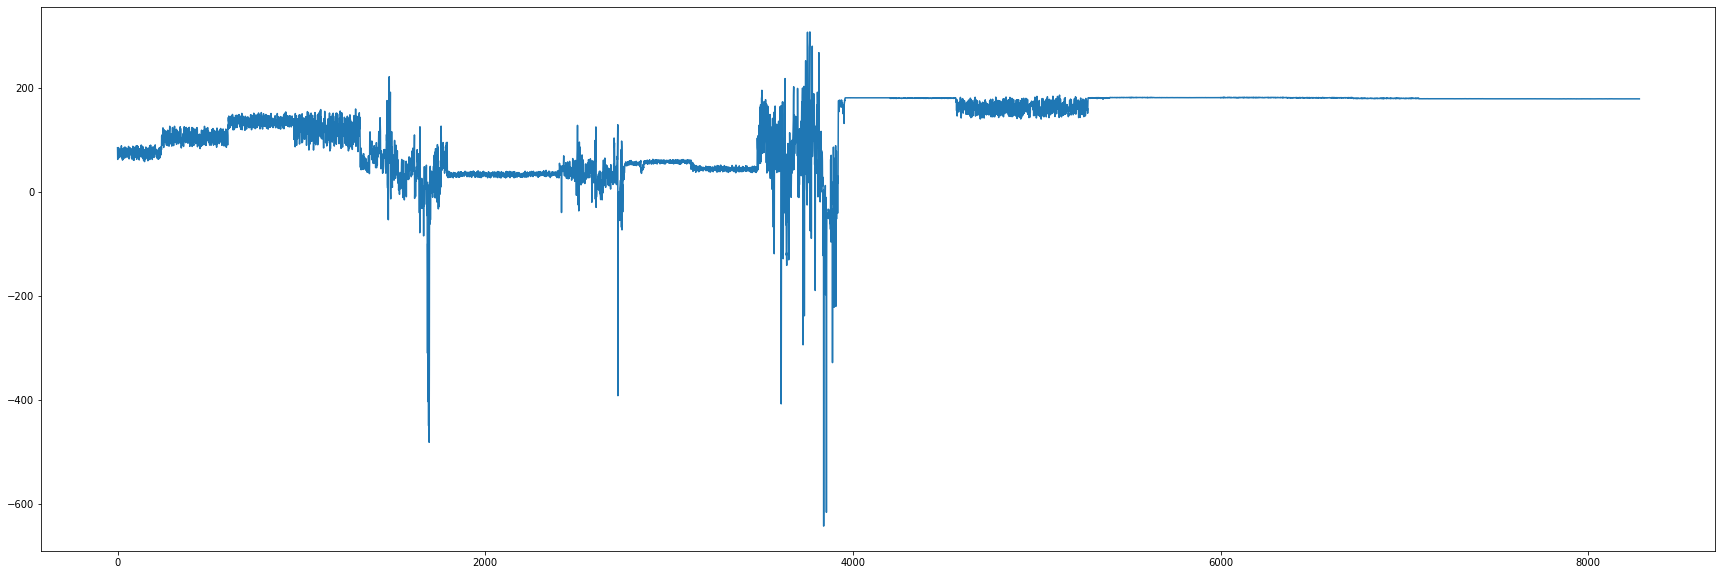

In [217]:
x = range(8279)
plt.figure(figsize=(30,10))
plt.plot(x, pre)
plt.show()

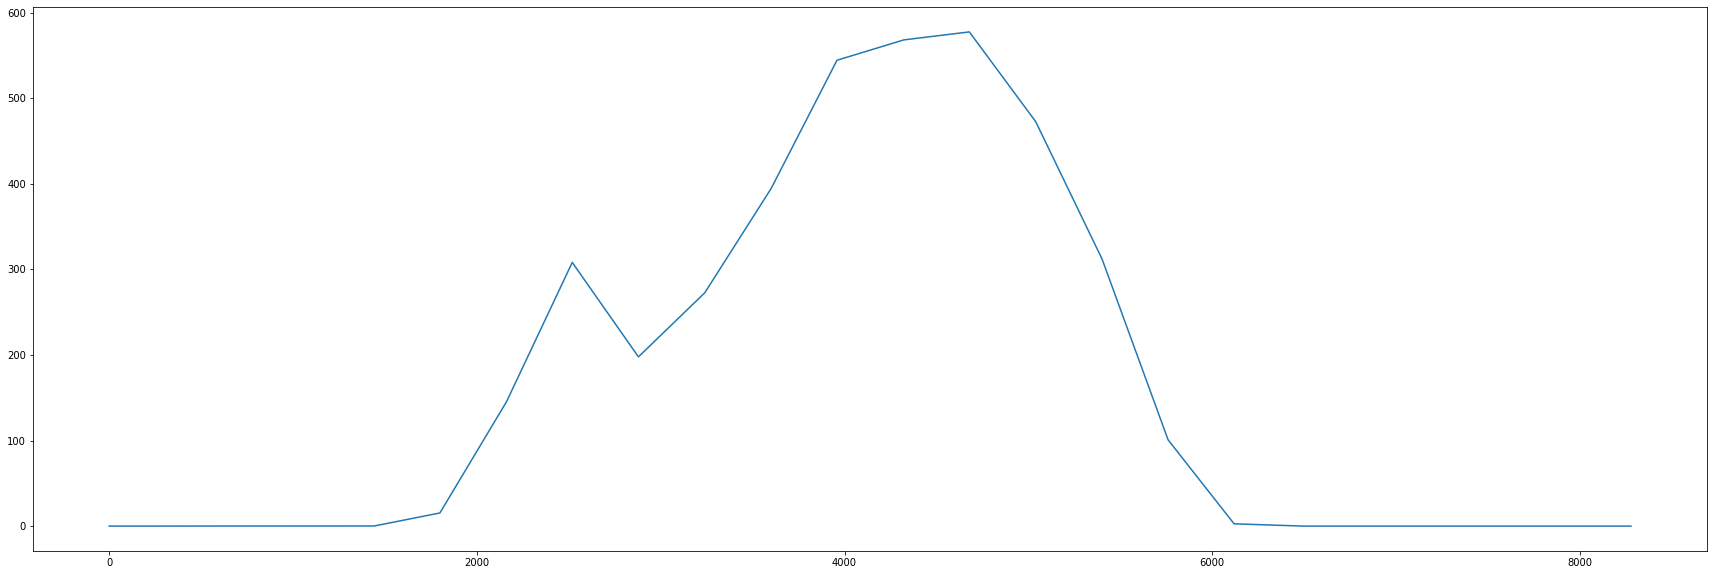

In [218]:
x = range(8279)
plt.figure(figsize=(30,10))
plt.plot(x, y_test)
plt.show()